In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import scipy.linalg
torch.set_default_dtype(torch.float64)

In [2]:
# hat map from vector space R^3 to Lie algebra so(3)
def hat(v):
    hat_v = torch.zeros([v.shape[0], 3, 3])
    hat_v[:, 0, 1], hat_v[:, 0, 2], hat_v[:, 1, 2] = -v[:, 2], v[:, 1], -v[:, 0]
    return hat_v + -hat_v.transpose(2, 1)

# Logarithmic map from SO(3) to R^3 (i.e. rotation vector)
def Log(R): return torch.tensor(Rotation.from_matrix(R.numpy()).as_rotvec())
    
# logarithmic map from SO(3) to so(3), this is the matrix logarithm
def log(R): return hat(Log(R))

# Exponential map from so(3) to SO(3), this is the matrix exponential
def exp(A): return torch.tensor(scipy.linalg.expm(A.numpy()))

# Angle of rotation SO(3) to R^+
def Omega(R): return log(R).norm(dim=[-2, -1])/torch.sqrt(torch.tensor(2.))

# exponential map from tangent space at R0 to SO(3)
def expmap(R0, tangent):
    skew_sym = torch.einsum('Nij,Nik->Njk', R0, tangent)
    return torch.einsum('Nij,Njk->Nik', R0, exp(skew_sym))

# Normal sample in tangent space at R0
def tangent_gaussian(R0): return torch.einsum('Nij,Njk->Nik', R0, hat(torch.randn(R0.shape[0], 3)))

# Power series expansion in the IGSO3 density.
def f_igso3(omega, t, L=500):
    ls = torch.arange(L)[None]  # of shape [1, L]
    return ((2*ls + 1) * torch.exp(-ls*(ls+1)*t/2) *
             torch.sin(omega[:, None]*(ls+1/2)) / torch.sin(omega[:, None]/2)).sum(dim=-1)

# IGSO3 density with respect to the volume form on SO(3)
def igso3_density(Rt, t, L=500): return f_igso3(Omega(Rt), t, L)

# grad_R log IGSO3(R; I_3, t)
def igso3_score(R, t, L=500):
    def d_logf_d_omega(omega, t):
        omega = omega.detach().requires_grad_(True)
        log_f = torch.log(f_igso3(omega, t, L))
        return torch.autograd.grad(log_f.sum(), omega)[0]
    omega = Omega(R)
    unit_vector = torch.einsum('Nij,Njk->Nik', R, log(R))/omega[:, None, None]
    return unit_vector * d_logf_d_omega(omega, t)[:, None, None]

In [3]:
# Sample N times from U(SO(3)) by inverting CDF of uniform distribution of angle 
def p_ref(N, M=1000):
    omega_grid = np.linspace(0, np.pi, M)
    cdf = np.cumsum(np.pi**-1 * (1-np.cos(omega_grid)), 0)/(M/np.pi)
    omegas = np.interp(np.random.rand(N), cdf, omega_grid)
    axes = np.random.randn(N, 3)
    axes = omegas[:, None]* axes/np.linalg.norm(axes, axis=-1, keepdims=True)
    return exp(hat(torch.tensor(axes)))

# Define discrete target measure on SO(3), and it's score for t>0
centers = p_ref(3) # Atoms defining target measure
def p_0(N): return centers[torch.randint(centers.shape[0], size=[N])]

# grad_Rt log p_t(Rt) for noised target measure
def score_t(Rt, t):
    Rt_to_cs = [torch.einsum('ij,Nik->Njk', c, Rt) for c in centers]  # c^-1 @ x
    p_Rt_by_cs = torch.stack([igso3_density(Rt_to_c, t) for Rt_to_c in Rt_to_cs], dim=0)
    score_by_c = [p_Rt_by_ck[:, None, None] * torch.einsum(
        'ij,Njk->Nik', ck, igso3_score(Rt_to_ck, t))
        for ck, p_Rt_by_ck, Rt_to_ck in zip(centers, p_Rt_by_cs, Rt_to_cs)]
    return sum(score_by_c)/p_Rt_by_cs.sum(dim=0)[:, None, None]

# Simluation procedure for forward and reverse
def geodesic_random_walk(p_initial, drift, ts):
    Rts = {ts[0]:p_initial()}
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # negative for reverse process
        Rts[ts[i]] = expmap(Rts[ts[i-1]],
            drift(Rts[ts[i-1]], ts[i-1]) * dt + tangent_gaussian(Rts[ts[i-1]]) * np.sqrt(abs(dt)))
    return Rts

In [4]:
N = 10000 # Number of samples
T = 4. # Final time 
ts = np.linspace(0, T, 200) # Discretization of [0, T]
forward_samples = geodesic_random_walk(
    p_initial=lambda: p_0(N), drift=lambda Rt, t: 0., ts=ts)
reverse_samples = geodesic_random_walk(
    p_initial=lambda: p_ref(N), drift=lambda Rt, t: -score_t(Rt, t), ts=ts[::-1])

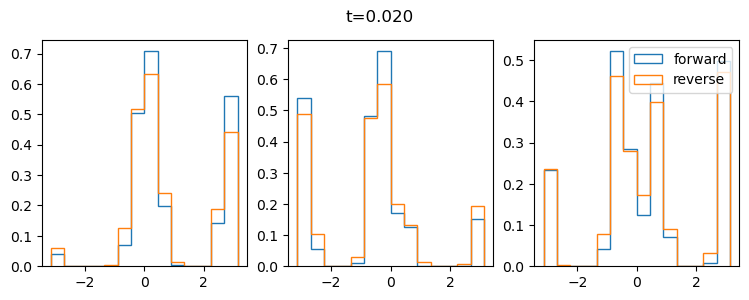

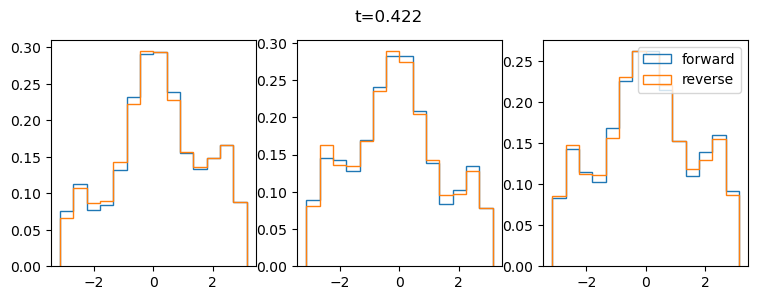

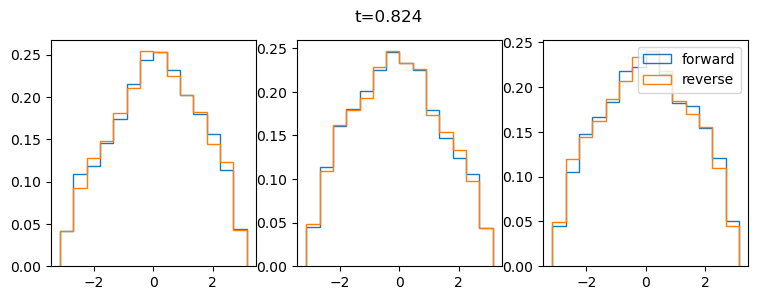

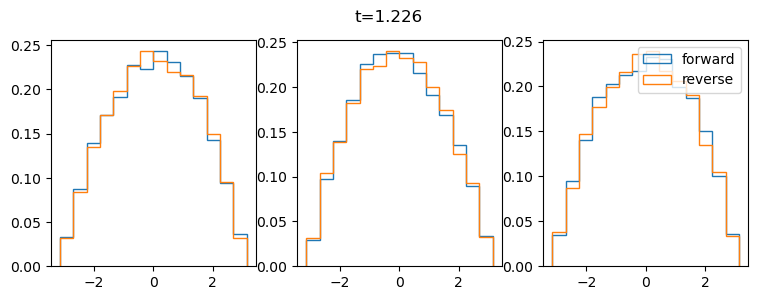

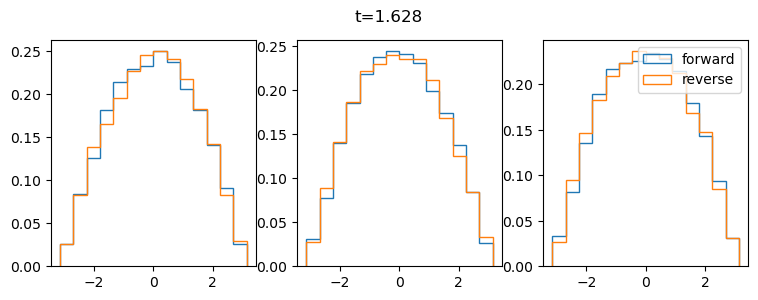

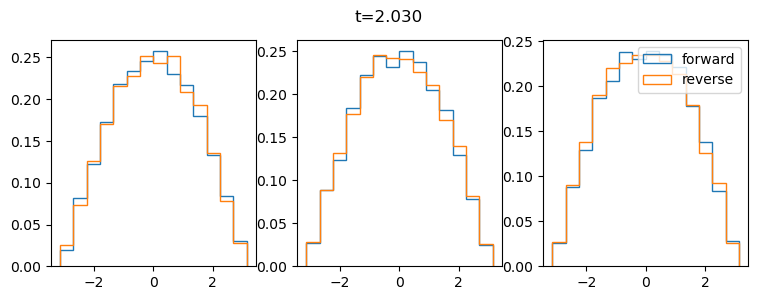

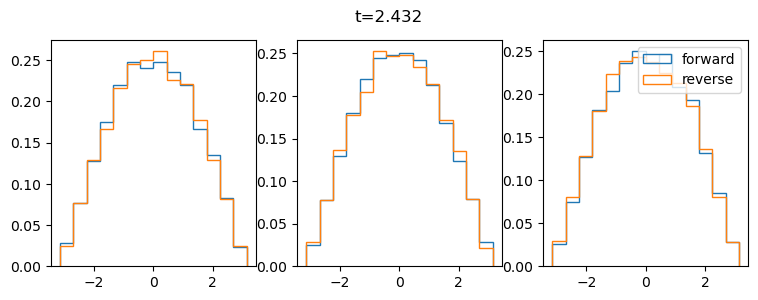

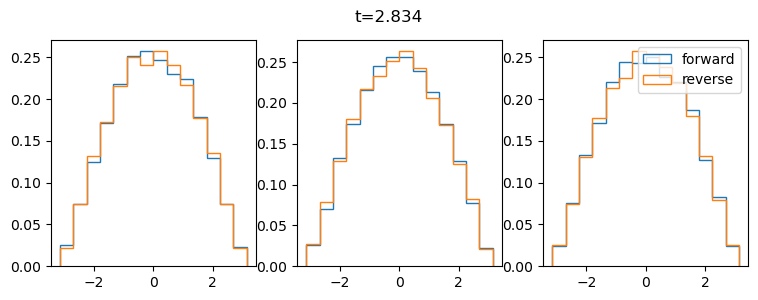

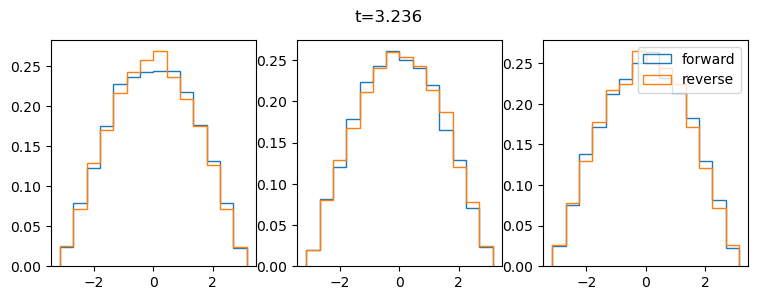

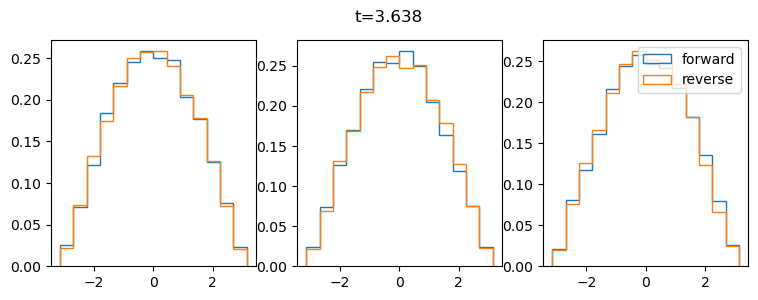

In [5]:
# Plot comparison of forward and reverse process
for i in range(1, len(ts), len(ts)//10):
    t = ts[i]
    Rt_forward = Log(forward_samples[ts[i]])
    Rt_reverse = Log(reverse_samples[ts[i]])
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(9, 3))
    fig.suptitle(f't={t:.3f}')
    bins = np.linspace(-np.pi, np.pi, 15)
    for Rt, label in [(Rt_forward, "forward"), (Rt_reverse, "reverse")]:
        for i in range(3): axs[i].hist(Rt[:, i].numpy(), bins, density=True, histtype='step', label=label)
    plt.legend()